# 1-D Convection-Diffusion equation

In this tutorial, we consider the **1D** convection-diffusion equation

$$
\frac{\partial u}{\partial t} + c \partial_x u - \nu \frac{\partial^2 u}{\partial x^2} = 0
$$

In [1]:
# needed imports
from numpy import zeros, ones, linspace, zeros_like
from matplotlib.pyplot import plot, show
%matplotlib inline

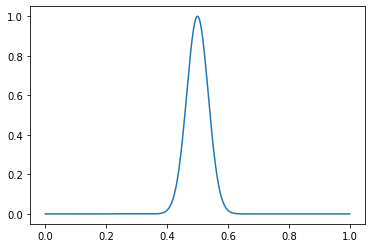

In [2]:
# Initial condition
import numpy as np
u0 = lambda x: np.exp(-(x-.5)**2/.05**2)

grid = linspace(0., 1., 401)
u = u0(grid) 
plot(grid, u) ; show()

### Time scheme

$$\frac{u^{n+1}-u^n}{\Delta t}  + c \partial_x u^{n+1} - \nu \partial_{xx} u^{n+1} = 0 $$

$$ \left(I + c \Delta t \partial_x - \nu \Delta t \partial_{xx} \right) u^{n+1} = u^n $$

### Weak formulation

$$
\langle v, u^{n+1} \rangle - c \Delta t ~ \langle \partial_x v, u^{n+1} \rangle + \nu \Delta t ~ \langle \partial_x v, \partial_x u^{n+1} \rangle = \langle v, u^n \rangle
$$
expending $u^n$ over the fem basis, we get the linear system

$$A U^{n+1} = M U^n$$

where

$$
M_{ij} = \langle b_i, b_j \rangle
$$

$$
A_{ij} = \langle b_i, b_j \rangle - c \Delta t ~ \langle \partial_x b_i, b_j \rangle + \nu \Delta t ~ \langle \partial_x b_i, \partial_x b_j \rangle
$$

## Abstract Model using SymPDE

In [3]:
from sympde.core import Constant
from sympde.expr import BilinearForm, LinearForm, integral
from sympde.topology import ScalarFunctionSpace, Line, element_of, dx
from sympde.topology import dx1 # TODO: this is a bug right now

In [4]:
# ... abstract model
domain = Line()

V = ScalarFunctionSpace('V', domain)

x = domain.coordinates

u,v = [element_of(V, name=i) for i in ['u', 'v']]

c = Constant('c')
nu = Constant('nu')
dt = Constant('dt')

# bilinear form
# expr = v*u - c*dt*dx(v)*u # TODO BUG not working
expr = v*u - c*dt*dx1(v)*u + nu*dt*dx1(v)*dx1(u)
a = BilinearForm((u,v), integral(domain , expr))

# bilinear form for the mass matrix
expr = u*v
m  = BilinearForm((u,v), integral(domain , expr))

# linear form for initial condition
from sympy import exp
expr = exp(-(x-.5)**2/.05**2)*v
l = LinearForm(v, integral(domain, expr))

## Discretization using Psydac

In [5]:
from psydac.api.discretization import discretize

In [6]:
c = 1     # wavespeed
nu = 0.01   # viscosity
T = 0.2  # T final time
dt = 0.001
niter = int(T / dt)

degree = [3]    # spline degree
ncells = [64]   # number of elements

In [7]:
# Create computational domain from topological domain
domain_h = discretize(domain, ncells=ncells, comm=None)

# Discrete spaces
Vh = discretize(V, domain_h, degree=degree)

# Discretize the bilinear forms
ah = discretize(a, domain_h, [Vh, Vh])
mh = discretize(m, domain_h, [Vh, Vh])

# Discretize the linear form for the initial condition
lh = discretize(l, domain_h, Vh)

In [8]:
# assemble matrices and convert them to scipy
M = mh.assemble().tosparse()
A = ah.assemble(c=c, nu=nu, dt=dt).tosparse()

# assemble the rhs and convert it to numpy array
rhs = lh.assemble().toarray()

In [9]:
from scipy.sparse.linalg import cg, gmres

In [10]:
# L2 projection of the initial condition
un, status = cg(M, rhs, tol=1.e-8, maxiter=5000) 

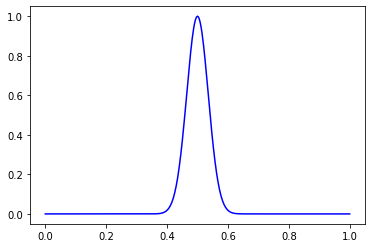

In [11]:
from simplines import plot_field_1d
plot_field_1d(Vh.knots[0], Vh.degree[0], un, nx=401)

In [12]:
for i in range(0, niter):
    b = M.dot(un)
    un, status = gmres(A, b, tol=1.e-8, maxiter=5000)

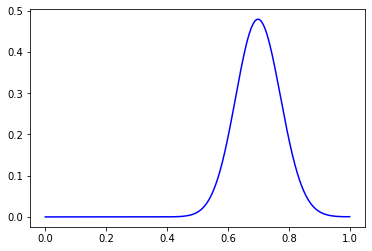

In [13]:
plot_field_1d(Vh.knots[0], Vh.degree[0], un, nx=401)